In [16]:
"""
Person B - Abundance Metrics Analysis (Self-Contained Version)
Birds Biodiversity Project - Section 2: Multi-Year Indicator Trends

Indicators analyzed:
1. Total Abundance - Raw population metric across all species
2. Mean Abundance per Point - Effort-standardized abundance metric

"""

# ============================================================================
# STANDARD IMPORTS
# ============================================================================
import sys
sys.path.append('../src')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Standard imports successful")

from data_io import load_excel_data, clean_observations, get_annual_summary
# ============================================================================
# INDICATOR COMPUTATION FUNCTIONS
# ============================================================================

def compute_total_abundance(df):
    """
    Compute total abundance (sum of all individual counts).
    """
    return df['individual_count'].sum()

def compute_mean_abundance_per_point(df):
    """
    Compute mean abundance per observation point.
    Standardizes for sampling effort by dividing total abundance
    by the number of unique observation points visited.
    """
    # Count unique observation points
    n_points = df[['transect_name', 'point_number']].drop_duplicates().shape[0]
    
    # Total abundance
    total_abundance = df['individual_count'].sum()
    
    # Mean per point
    if n_points > 0:
        return total_abundance / n_points
    else:
        return 0

print("✓ Indicator functions defined")

# ============================================================================
# STATISTICAL UTILITIES
# ============================================================================

def bootstrap_ci(data, statistic_func, n_boot=1000, confidence_level=0.95):
    """
    Compute bootstrap confidence interval for a statistic.
    
    Parameters
    ----------
    data : pd.DataFrame
        Data to bootstrap
    statistic_func : callable
        Function that computes the statistic from data
    n_boot : int
        Number of bootstrap iterations
    confidence_level : float
        Confidence level (e.g., 0.95 for 95% CI)
        
    Returns
    -------
    dict
        Dictionary with 'estimate', 'lower', 'upper', 'stderr'
    """
    # Original estimate
    estimate = statistic_func(data)
    
    # Bootstrap resampling
    boot_stats = []
    n = len(data)
    
    for _ in range(n_boot):
        # Resample with replacement
        sample = data.sample(n=n, replace=True)
        boot_stats.append(statistic_func(sample))
    
    boot_stats = np.array(boot_stats)
    
    # Compute confidence interval
    alpha = 1 - confidence_level
    lower = np.percentile(boot_stats, 100 * alpha / 2)
    upper = np.percentile(boot_stats, 100 * (1 - alpha / 2))
    stderr = np.std(boot_stats)
    
    return {
        'estimate': estimate,
        'lower': lower,
        'upper': upper,
        'stderr': stderr
    }

def fit_linear_trend(x, y):
    """
    Fit linear trend model and return comprehensive results.
    
    Parameters
    ----------
    x : array-like
        Independent variable (e.g., years)
    y : array-like
        Dependent variable (e.g., indicator values)
        
    Returns
    -------
    dict
        Model results including slope, intercept, R², p-value, fitted values, residuals
    """
    # Fit linear model
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Predict values
    y_pred = slope * x + intercept
    residuals = y - y_pred
    
    # Compute 95% CI for slope
    n = len(x)
    t_val = stats.t.ppf(0.975, n - 2)  # 95% two-tailed
    slope_ci = (slope - t_val * std_err, slope + t_val * std_err)
    
    return {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value,
        'std_err': std_err,
        'slope_ci': slope_ci,
        'residuals': residuals,
        'fitted': y_pred
    }

def check_assumptions(residuals, fitted):
    """
    Check linear regression assumptions.
    
    Returns diagnostic statistics for:
    - Normality (Shapiro-Wilk test)
    - Homoscedasticity (correlation between |residuals| and fitted)
    - Independence (Durbin-Watson statistic)
    """
    # Normality
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    
    # Homoscedasticity
    abs_resid = np.abs(residuals)
    het_corr, het_p = stats.pearsonr(fitted, abs_resid)
    
    # Autocorrelation (Durbin-Watson)
    dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
    
    return {
        'normality': {'statistic': shapiro_stat, 'p_value': shapiro_p, 'pass': shapiro_p > 0.05},
        'homoscedasticity': {'correlation': het_corr, 'p_value': het_p, 'pass': het_p > 0.05},
        'independence': {'durbin_watson': dw, 'pass': 1.5 < dw < 2.5}
    }

print("✓ Statistical utilities defined")

# ============================================================================
# PLOTTING UTILITIES
# ============================================================================

def plot_temporal_trend(x_data, y_data, ci_lower, ci_upper, y_trend,
                       xlabel, ylabel, title, filename, color='steelblue',
                       trend_info=None):
    """
    Create publication-quality temporal trend plot.
    
    Parameters
    ----------
    x_data : array-like
        X-axis values (years)
    y_data : array-like
        Y-axis values (indicator estimates)
    ci_lower, ci_upper : array-like
        Confidence interval bounds
    y_trend : array-like
        Fitted trend line values
    xlabel, ylabel, title : str
        Axis labels and title
    filename : str
        Path to save figure
    color : str
        Color for data points and CI
    trend_info : dict, optional
        Dictionary with slope, r_squared, p_value for text box
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot data and CI
    ax.plot(x_data, y_data, 'o-', linewidth=2.5, markersize=10, 
            label='Observed', color=color, markeredgecolor='black', markeredgewidth=1)
    ax.fill_between(x_data, ci_lower, ci_upper, alpha=0.25, color=color, 
                     label='95% CI (Bootstrap)')
    
    # Plot trend line
    ax.plot(x_data, y_trend, '--', linewidth=2.5, color='red', label='Linear Trend')
    
    # Labels
    ax.set_xlabel(xlabel, fontsize=13, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add trend info box if provided
    if trend_info:
        textstr = f'Slope: {trend_info["slope"]:+.4g}\n'
        textstr += f'R² = {trend_info["r_squared"]:.3f}\n'
        textstr += f'p = {trend_info["p_value"]:.4f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=props)
    
    ax.legend(frameon=True, loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_data.min() - 0.5, x_data.max() + 0.5)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Figure saved to {filename}")
    plt.show()

print("✓ Plotting utilities defined")

print("\n" + "="*60)
print("ALL FUNCTIONS LOADED SUCCESSFULLY")
print("="*60)

✓ Standard imports successful
✓ Indicator functions defined
✓ Statistical utilities defined
✓ Plotting utilities defined

ALL FUNCTIONS LOADED SUCCESSFULLY


In [17]:
"""
Load data and filter to complete years (2015-2024)
Excludes partial years 2014 and 2025
"""

print("=" * 60)
print("LOADING DATA")
print("=" * 60)

# Load raw data
data = load_excel_data('../data/raw/Observations 2012-2025.xlsx')
df_raw = data['observations']

print(f"\nRaw data loaded: {len(df_raw)} observations")

# Clean data
df = clean_observations(df_raw)

print(f"After cleaning: {len(df)} observations")

# Filter to complete years only (2015-2024)
df_complete = df[df['year'].between(2015, 2024)].copy()

print(f"After filtering to 2015-2024: {len(df_complete)} observations")
print(f"Years included: {sorted(df_complete['year'].unique())}")

# Verify data quality
print("\n" + "=" * 60)
print("DATA QUALITY CHECKS")
print("=" * 60)
print(f"Unique species: {df_complete['species_name'].nunique()}")
print(f"Unique transects: {df_complete['transect_name'].nunique()}")
print(f"Unique observers: {df_complete['observer_name'].nunique()}")
print(f"Total birds counted: {df_complete['individual_count'].sum():,.0f}")
print(f"Mean count per observation: {df_complete['individual_count'].mean():.2f}")

LOADING DATA
Loading data from ../data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records

Raw data loaded: 114497 observations
Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014.0 - 2025.0
  Unique species: 102
  Unique transects: 72
  Unique observers: 42
After cleaning: 114493 observations
After filtering to 2015-2024: 99344 observations
Years included: [np.float64(2015.0), np.float64(2016.0), np.float64(2017.0), np.float64(2018.0), np.float64(2019.0), np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]

DATA QUALITY CHECKS
Unique species: 98
Unique transects: 70
Unique observers: 41
Total birds counted: 651,845
Mean count per observation: 6.56


In [18]:
"""
Define functions for computing abundance metrics
"""

def compute_mean_abundance_per_point(df):
    """
    Compute mean abundance per observation point.
    
    This standardizes for sampling effort by dividing total abundance
    by the number of unique observation points visited.
    
    Parameters
    ----------
    df : pd.DataFrame
        Observations with 'individual_count', 'transect_name', 'point_number'
        
    Returns
    -------
    float
        Mean abundance per point
    """
    # Count unique observation points (transect-point combinations)
    n_points = df[['transect_name', 'point_number']].drop_duplicates().shape[0]
    
    # Total abundance
    total_abundance = df['individual_count'].sum()
    
    # Mean per point
    if n_points > 0:
        return total_abundance / n_points
    else:
        return 0

# Test the function
test_year = df_complete[df_complete['year'] == 2020]
test_total = test_year['individual_count'].sum()
test_mean = compute_mean_abundance_per_point(test_year)

print("Function test (2020):")
print(f"  Total abundance: {test_total:,.0f}")
print(f"  Mean per point: {test_mean:.2f}")
print("✓ Functions defined successfully")

Function test (2020):
  Total abundance: 66,171
  Mean per point: 105.03
✓ Functions defined successfully


In [19]:
"""
Compute both indicators for each year (2015-2024)
"""

print("=" * 60)
print("COMPUTING ANNUAL INDICATORS")
print("=" * 60)

years = sorted(df_complete['year'].unique())

# Initialize results
results = []

for year in years:
    year_data = df_complete[df_complete['year'] == year]
    
    # Indicator 1: Total Abundance
    total_abundance = year_data['individual_count'].sum()
    
    # Indicator 2: Mean Abundance per Point
    mean_abundance_per_point = compute_mean_abundance_per_point(year_data)
    
    # Store results
    results.append({
        'year': year,
        'total_abundance': total_abundance,
        'mean_abundance_per_point': mean_abundance_per_point,
        'n_observations': len(year_data),
        'n_points': year_data[['transect_name', 'point_number']].drop_duplicates().shape[0]
    })
    
    print(f"\n{year}:")
    print(f"  Total Abundance: {total_abundance:>10,.0f} individuals")
    print(f"  Mean per Point:  {mean_abundance_per_point:>10,.2f} individuals/point")
    print(f"  Observations:    {len(year_data):>10,}")
    print(f"  Points surveyed: {year_data[['transect_name', 'point_number']].drop_duplicates().shape[0]:>10,}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print("\nTotal Abundance:")
print(results_df['total_abundance'].describe())
print("\nMean Abundance per Point:")
print(results_df['mean_abundance_per_point'].describe())

COMPUTING ANNUAL INDICATORS

2015.0:
  Total Abundance:     52,453 individuals
  Mean per Point:       98.97 individuals/point
  Observations:         8,162
  Points surveyed:        530

2016.0:
  Total Abundance:     69,062 individuals
  Mean per Point:      117.05 individuals/point
  Observations:        11,010
  Points surveyed:        590

2017.0:
  Total Abundance:     61,685 individuals
  Mean per Point:      102.81 individuals/point
  Observations:         9,228
  Points surveyed:        600

2018.0:
  Total Abundance:     61,208 individuals
  Mean per Point:       95.49 individuals/point
  Observations:         9,733
  Points surveyed:        641

2019.0:
  Total Abundance:     63,217 individuals
  Mean per Point:       99.24 individuals/point
  Observations:         9,572
  Points surveyed:        637

2020.0:
  Total Abundance:     66,171 individuals
  Mean per Point:      105.03 individuals/point
  Observations:         9,956
  Points surveyed:        630

2021.0:
  Total A

In [20]:
"""
Compute bootstrap confidence intervals for Total Abundance
Uses 1000 bootstrap iterations per year
"""

print("=" * 60)
print("BOOTSTRAP CIs: TOTAL ABUNDANCE")
print("=" * 60)

def total_abundance_stat(data):
    """Statistic function for bootstrap"""
    return data['individual_count'].sum()

n_boot = 1000
confidence_level = 0.95

total_abundance_cis = []

for year in years:
    print(f"\nBootstrapping {year}...", end=" ")
    year_data = df_complete[df_complete['year'] == year]
    
    # Bootstrap
    boot_estimates = []
    n = len(year_data)
    
    for _ in range(n_boot):
        # Resample observations with replacement
        sample = year_data.sample(n=n, replace=True)
        boot_estimates.append(total_abundance_stat(sample))
    
    boot_estimates = np.array(boot_estimates)
    
    # Compute CI
    alpha = 1 - confidence_level
    estimate = total_abundance_stat(year_data)
    ci_lower = np.percentile(boot_estimates, 100 * alpha / 2)
    ci_upper = np.percentile(boot_estimates, 100 * (1 - alpha / 2))
    stderr = np.std(boot_estimates)
    
    total_abundance_cis.append({
        'year': year,
        'estimate': estimate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'stderr': stderr,
        'ci_width': ci_upper - ci_lower
    })
    
    print(f"✓ [{ci_lower:,.0f}, {ci_upper:,.0f}]")

# Convert to DataFrame
total_abundance_ci_df = pd.DataFrame(total_abundance_cis)

print("\n" + "=" * 60)
print("CI Summary:")
print(total_abundance_ci_df[['year', 'estimate', 'ci_lower', 'ci_upper', 'ci_width']])

BOOTSTRAP CIs: TOTAL ABUNDANCE

Bootstrapping 2015.0... ✓ [51,154, 53,831]

Bootstrapping 2016.0... ✓ [67,751, 70,442]

Bootstrapping 2017.0... ✓ [60,399, 63,215]

Bootstrapping 2018.0... ✓ [59,627, 62,869]

Bootstrapping 2019.0... ✓ [61,844, 64,694]

Bootstrapping 2020.0... ✓ [64,565, 67,879]

Bootstrapping 2021.0... ✓ [70,250, 74,035]

Bootstrapping 2022.0... ✓ [71,661, 75,555]

Bootstrapping 2023.0... ✓ [65,605, 68,626]

Bootstrapping 2024.0... ✓ [64,039, 66,876]

CI Summary:
     year      estimate      ci_lower     ci_upper     ci_width
0  2015.0  52453.000000  51153.700000  53831.12500  2677.425000
1  2016.0  69062.000000  67750.950000  70442.27500  2691.325000
2  2017.0  61685.380952  60398.905952  63214.57619  2815.670238
3  2018.0  61208.000000  59626.725000  62869.02500  3242.300000
4  2019.0  63217.000000  61843.825000  64694.07500  2850.250000
5  2020.0  66171.000000  64564.750000  67879.25000  3314.500000
6  2021.0  72048.000000  70249.825000  74034.72500  3784.900000
7  2

In [21]:
"""
Fit linear trend model for Total Abundance
"""

print("=" * 60)
print("TEMPORAL TREND: TOTAL ABUNDANCE")
print("=" * 60)

# Prepare data
x = np.array(years)
y = total_abundance_ci_df['estimate'].values

# Fit linear model
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Compute 95% CI for slope
n = len(x)
t_val = stats.t.ppf(0.975, n - 2)  # 95% CI
slope_ci_lower = slope - t_val * std_err
slope_ci_upper = slope + t_val * std_err

# Predictions
y_pred = slope * x + intercept
residuals = y - y_pred

# Store results
total_abundance_trend = {
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_value**2,
    'p_value': p_value,
    'slope_ci': (slope_ci_lower, slope_ci_upper),
    'residuals': residuals,
    'fitted': y_pred
}

print(f"\nLinear Trend Results:")
print(f"  Slope: {slope:+.2f} individuals/year")
print(f"  95% CI: [{slope_ci_lower:+.2f}, {slope_ci_upper:+.2f}]")
print(f"  R² = {r_value**2:.4f}")
print(f"  p-value = {p_value:.4f}")

if p_value < 0.001:
    sig_str = "p < 0.001 ***"
elif p_value < 0.01:
    sig_str = "p < 0.01 **"
elif p_value < 0.05:
    sig_str = "p < 0.05 *"
else:
    sig_str = "p ≥ 0.05 (not significant)"

print(f"  Significance: {sig_str}")

# Interpret trend direction
if slope > 0:
    direction = "INCREASING"
elif slope < 0:
    direction = "DECREASING"
else:
    direction = "STABLE"

print(f"\n  → Trend direction: {direction}")
print(f"  → Total change 2015-2024: {slope * 9:+,.0f} individuals ({slope * 9 / y[0] * 100:+.1f}%)")

TEMPORAL TREND: TOTAL ABUNDANCE

Linear Trend Results:
  Slope: +1195.36 individuals/year
  95% CI: [-113.94, +2504.66]
  R² = 0.3565
  p-value = 0.0684
  Significance: p ≥ 0.05 (not significant)

  → Trend direction: INCREASING
  → Total change 2015-2024: +10,758 individuals (+20.5%)


In [22]:
"""
Check linear regression assumptions for Total Abundance model
"""

print("=" * 60)
print("ASSUMPTION CHECKS: TOTAL ABUNDANCE")
print("=" * 60)

# 1. Normality of residuals (Shapiro-Wilk test)
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n1. Normality (Shapiro-Wilk test):")
print(f"   Statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print(f"   ✓ Residuals appear normally distributed")
else:
    print(f"   ⚠ Residuals may not be normally distributed")

# 2. Homoscedasticity (check correlation between |residuals| and fitted)
abs_resid = np.abs(residuals)
het_corr, het_p = stats.pearsonr(y_pred, abs_resid)
print(f"\n2. Homoscedasticity:")
print(f"   Correlation(fitted, |residuals|) = {het_corr:.4f}, p-value = {het_p:.4f}")
if het_p > 0.05:
    print(f"   ✓ Variance appears constant")
else:
    print(f"   ⚠ Possible heteroscedasticity")

# 3. Independence (Durbin-Watson statistic)
dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
print(f"\n3. Independence (Durbin-Watson):")
print(f"   DW statistic = {dw:.4f}")
if 1.5 < dw < 2.5:
    print(f"   ✓ No strong autocorrelation detected")
else:
    print(f"   ⚠ Possible autocorrelation (DW should be near 2)")

print("\n" + "=" * 60)

ASSUMPTION CHECKS: TOTAL ABUNDANCE

1. Normality (Shapiro-Wilk test):
   Statistic = 0.9537, p-value = 0.7118
   ✓ Residuals appear normally distributed

2. Homoscedasticity:
   Correlation(fitted, |residuals|) = -0.1836, p-value = 0.6116
   ✓ Variance appears constant

3. Independence (Durbin-Watson):
   DW statistic = 1.9124
   ✓ No strong autocorrelation detected



In [23]:
"""
Compute bootstrap confidence intervals for Mean Abundance per Point
Uses 1000 bootstrap iterations per year
"""

print("=" * 60)
print("BOOTSTRAP CIs: MEAN ABUNDANCE PER POINT")
print("=" * 60)


def mean_abundance_stat(data):
    """Statistic function for bootstrap (mean abundance per point)."""
    return compute_mean_abundance_per_point(data)

n_boot = 1000
confidence_level = 0.95

mean_abundance_cis = []

for year in years:
    print(f"\nBootstrapping {year}...", end=" ")
    year_data = df_complete[df_complete['year'] == year]

    # Bootstrap
    boot_estimates = []
    n = len(year_data)

    for _ in range(n_boot):
        # Resample observations with replacement
        sample = year_data.sample(n=n, replace=True)
        boot_estimates.append(mean_abundance_stat(sample))

    boot_estimates = np.array(boot_estimates)

    # Compute CI
    alpha = 1 - confidence_level
    estimate = mean_abundance_stat(year_data)
    ci_lower = np.percentile(boot_estimates, 100 * alpha / 2)
    ci_upper = np.percentile(boot_estimates, 100 * (1 - alpha / 2))
    stderr = np.std(boot_estimates)

    mean_abundance_cis.append({
        'year': year,
        'estimate': estimate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'stderr': stderr,
        'ci_width': ci_upper - ci_lower
    })

    print(f"✓ [{ci_lower:.2f}, {ci_upper:.2f}]")

# Convert to DataFrame
mean_abundance_ci_df = pd.DataFrame(mean_abundance_cis)

print("\n" + "=" * 60)
print("CI Summary:")
print(mean_abundance_ci_df[['year', 'estimate', 'ci_lower', 'ci_upper', 'ci_width']])


BOOTSTRAP CIs: MEAN ABUNDANCE PER POINT

Bootstrapping 2015.0... ✓ [96.53, 101.71]

Bootstrapping 2016.0... ✓ [114.85, 119.33]

Bootstrapping 2017.0... ✓ [100.60, 105.17]

Bootstrapping 2018.0... ✓ [93.07, 98.39]

Bootstrapping 2019.0... ✓ [97.06, 101.68]

Bootstrapping 2020.0... ✓ [102.36, 108.00]

Bootstrapping 2021.0... ✓ [111.73, 117.90]

Bootstrapping 2022.0... ✓ [114.06, 119.74]

Bootstrapping 2023.0... ✓ [102.79, 107.38]

Bootstrapping 2024.0... ✓ [98.77, 103.23]

CI Summary:
     year    estimate    ci_lower    ci_upper  ci_width
0  2015.0   98.967925   96.529670  101.705660  5.175991
1  2016.0  117.054237  114.847415  119.327458  4.480042
2  2017.0  102.808968  100.599925  105.170972  4.571048
3  2018.0   95.488300   93.068526   98.387715  5.319189
4  2019.0   99.241758   97.063736  101.677029  4.613293
5  2020.0  105.033333  102.355425  107.997215  5.641790
6  2021.0  114.726115  111.729061  117.901791  6.172731
7  2022.0  116.744444  114.058532  119.739960  5.681429
8  2023.

In [24]:
"""
Fit linear trend model for Mean Abundance per Point
"""

print("=" * 60)
print("TEMPORAL TREND: MEAN ABUNDANCE PER POINT")
print("=" * 60)

# Prepare data
x = np.array(years)
y = mean_abundance_ci_df['estimate'].values

# Fit linear model
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Compute 95% CI for slope
slope_ci_lower = slope - t_val * std_err
slope_ci_upper = slope + t_val * std_err

# Predictions
y_pred = slope * x + intercept
residuals = y - y_pred

# Store results
mean_abundance_trend = {
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_value**2,
    'p_value': p_value,
    'slope_ci': (slope_ci_lower, slope_ci_upper),
    'residuals': residuals,
    'fitted': y_pred
}

print(f"\nLinear Trend Results:")
print(f"  Slope: {slope:+.4f} individuals/point/year")
print(f"  95% CI: [{slope_ci_lower:+.4f}, {slope_ci_upper:+.4f}]")
print(f"  R² = {r_value**2:.4f}")
print(f"  p-value = {p_value:.4f}")

if p_value < 0.001:
    sig_str = "p < 0.001 ***"
elif p_value < 0.01:
    sig_str = "p < 0.01 **"
elif p_value < 0.05:
    sig_str = "p < 0.05 *"
else:
    sig_str = "p ≥ 0.05 (not significant)"

print(f"  Significance: {sig_str}")

# Interpret trend direction
if slope > 0:
    direction = "INCREASING"
elif slope < 0:
    direction = "DECREASING"
else:
    direction = "STABLE"

print(f"\n  → Trend direction: {direction}")
print(f"  → Total change 2015-2024: {slope * 9:+.4f} individuals/point ({slope * 9 / y[0] * 100:+.1f}%)")

TEMPORAL TREND: MEAN ABUNDANCE PER POINT

Linear Trend Results:
  Slope: +0.3911 individuals/point/year
  95% CI: [-1.7037, +2.4860]
  R² = 0.0226
  p-value = 0.6781
  Significance: p ≥ 0.05 (not significant)

  → Trend direction: INCREASING
  → Total change 2015-2024: +3.5203 individuals/point (+3.6%)


In [25]:
"""
Check linear regression assumptions for Mean Abundance per Point model
"""

print("=" * 60)
print("ASSUMPTION CHECKS: MEAN ABUNDANCE PER POINT")
print("=" * 60)

# 1. Normality
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n1. Normality (Shapiro-Wilk test):")
print(f"   Statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print(f"   ✓ Residuals appear normally distributed")
else:
    print(f"   ⚠ Residuals may not be normally distributed")

# 2. Homoscedasticity
abs_resid = np.abs(residuals)
het_corr, het_p = stats.pearsonr(y_pred, abs_resid)
print(f"\n2. Homoscedasticity:")
print(f"   Correlation(fitted, |residuals|) = {het_corr:.4f}, p-value = {het_p:.4f}")
if het_p > 0.05:
    print(f"   ✓ Variance appears constant")
else:
    print(f"   ⚠ Possible heteroscedasticity")

# 3. Independence
dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
print(f"\n3. Independence (Durbin-Watson):")
print(f"   DW statistic = {dw:.4f}")
if 1.5 < dw < 2.5:
    print(f"   ✓ No strong autocorrelation detected")
else:
    print(f"   ⚠ Possible autocorrelation")

print("\n" + "=" * 60)

ASSUMPTION CHECKS: MEAN ABUNDANCE PER POINT

1. Normality (Shapiro-Wilk test):
   Statistic = 0.8887, p-value = 0.1640
   ✓ Residuals appear normally distributed

2. Homoscedasticity:
   Correlation(fitted, |residuals|) = -0.1214, p-value = 0.7383
   ✓ Variance appears constant

3. Independence (Durbin-Watson):
   DW statistic = 1.6268
   ✓ No strong autocorrelation detected



✓ Diagnostic plots saved to ../figures/diagnostics_person_B.png


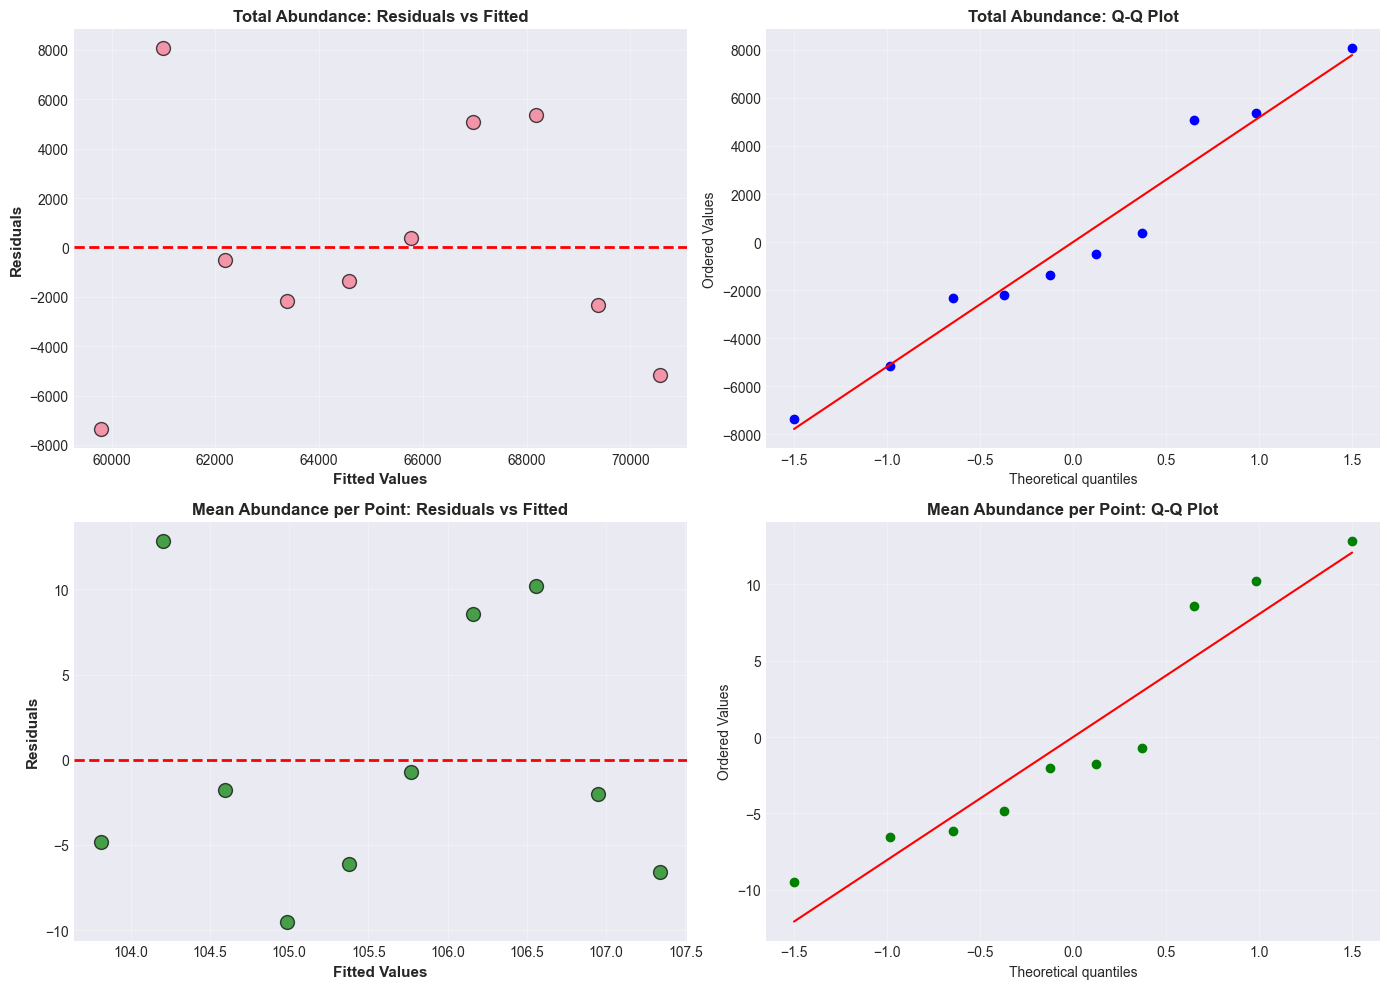

In [26]:
"""
Create diagnostic plots for both models
"""

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# === TOTAL ABUNDANCE DIAGNOSTICS ===
residuals_total = total_abundance_trend['residuals']
fitted_total = total_abundance_trend['fitted']

# Residuals vs Fitted
axes[0, 0].scatter(fitted_total, residuals_total, s=100, alpha=0.7, edgecolors='black')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Total Abundance: Residuals vs Fitted', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(residuals_total, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Total Abundance: Q-Q Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# === MEAN ABUNDANCE PER POINT DIAGNOSTICS ===
residuals_mean = mean_abundance_trend['residuals']
fitted_mean = mean_abundance_trend['fitted']

# Residuals vs Fitted
axes[1, 0].scatter(fitted_mean, residuals_mean, s=100, alpha=0.7, edgecolors='black', color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Fitted Values', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Mean Abundance per Point: Residuals vs Fitted', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(residuals_mean, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Mean Abundance per Point: Q-Q Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].get_lines()[0].set_color('green')
axes[1, 1].get_lines()[1].set_color('red')

plt.tight_layout()
plt.savefig('../figures/diagnostics_person_B.png', dpi=300, bbox_inches='tight')
print("✓ Diagnostic plots saved to ../figures/diagnostics_person_B.png")
plt.show()

✓ Figure saved to ../figures/indicator_total_abundance.png


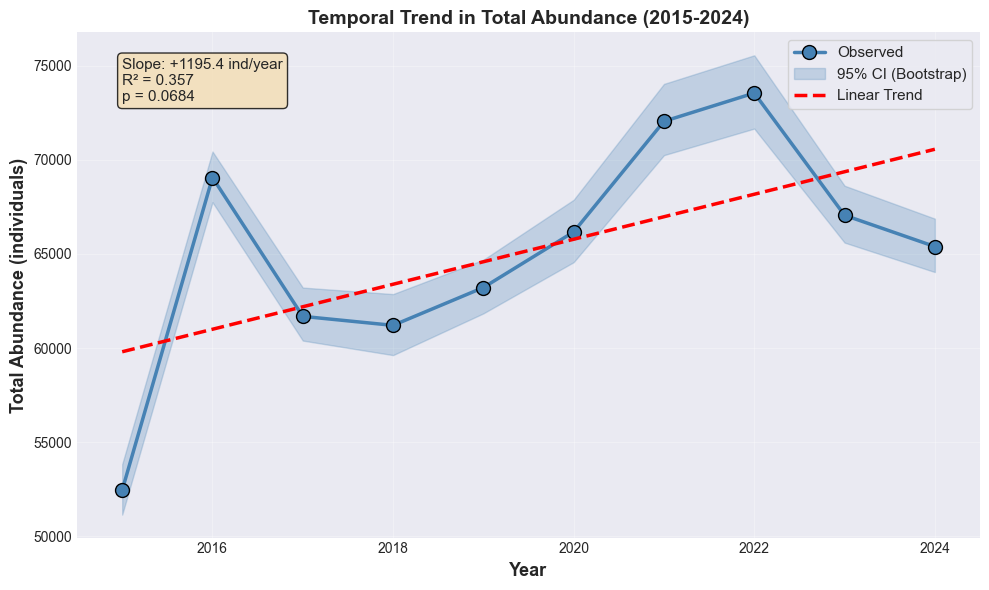

In [27]:
"""
Create publication-quality figure for Total Abundance
"""

fig, ax = plt.subplots(figsize=(10, 6))

# Extract data
x_data = total_abundance_ci_df['year'].values
y_data = total_abundance_ci_df['estimate'].values
ci_lower = total_abundance_ci_df['ci_lower'].values
ci_upper = total_abundance_ci_df['ci_upper'].values

# Plot data points and confidence interval
ax.plot(x_data, y_data, 'o-', linewidth=2.5, markersize=10, 
        label='Observed', color='steelblue', markeredgecolor='black', markeredgewidth=1)
ax.fill_between(x_data, ci_lower, ci_upper, alpha=0.25, color='steelblue', 
                 label='95% CI (Bootstrap)')

# Plot trend line
x_trend = np.array(years)
y_trend = total_abundance_trend['fitted']
ax.plot(x_trend, y_trend, '--', linewidth=2.5, color='red', label='Linear Trend')

# Labels and title
ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Abundance (individuals)', fontsize=13, fontweight='bold')
ax.set_title('Temporal Trend in Total Abundance (2015-2024)', fontsize=14, fontweight='bold')

# Add trend statistics box
textstr = f'Slope: {total_abundance_trend["slope"]:+.1f} ind/year\n'
textstr += f'R² = {total_abundance_trend["r_squared"]:.3f}\n'
textstr += f'p = {total_abundance_trend["p_value"]:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.legend(frameon=True, loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(2014.5, 2024.5)

plt.tight_layout()
plt.savefig('../figures/indicator_total_abundance.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to ../figures/indicator_total_abundance.png")
plt.show()

✓ Figure saved to ../figures/indicator_mean_abundance_per_point.png


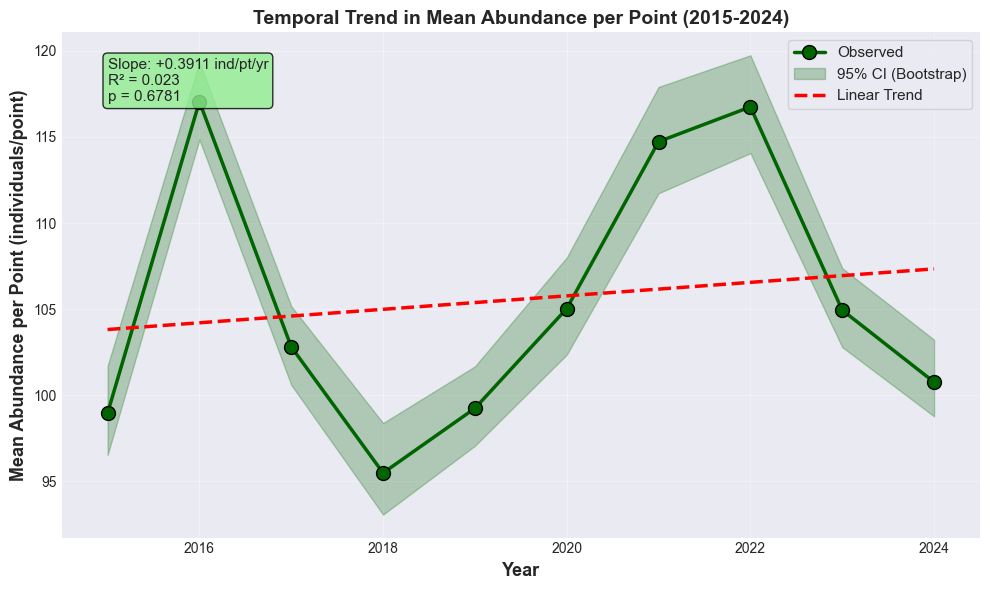

In [28]:
"""
Create publication-quality figure for Mean Abundance per Point
"""

fig, ax = plt.subplots(figsize=(10, 6))

# Extract data
x_data = mean_abundance_ci_df['year'].values
y_data = mean_abundance_ci_df['estimate'].values
ci_lower = mean_abundance_ci_df['ci_lower'].values
ci_upper = mean_abundance_ci_df['ci_upper'].values

# Plot data points and confidence interval
ax.plot(x_data, y_data, 'o-', linewidth=2.5, markersize=10, 
        label='Observed', color='darkgreen', markeredgecolor='black', markeredgewidth=1)
ax.fill_between(x_data, ci_lower, ci_upper, alpha=0.25, color='darkgreen', 
                 label='95% CI (Bootstrap)')

# Plot trend line
x_trend = np.array(years)
y_trend = mean_abundance_trend['fitted']
ax.plot(x_trend, y_trend, '--', linewidth=2.5, color='red', label='Linear Trend')

# Labels and title
ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Abundance per Point (individuals/point)', fontsize=13, fontweight='bold')
ax.set_title('Temporal Trend in Mean Abundance per Point (2015-2024)', fontsize=14, fontweight='bold')

# Add trend statistics box
textstr = f'Slope: {mean_abundance_trend["slope"]:+.4f} ind/pt/yr\n'
textstr += f'R² = {mean_abundance_trend["r_squared"]:.3f}\n'
textstr += f'p = {mean_abundance_trend["p_value"]:.4f}'
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.legend(frameon=True, loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(2014.5, 2024.5)

plt.tight_layout()
plt.savefig('../figures/indicator_mean_abundance_per_point.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to ../figures/indicator_mean_abundance_per_point.png")
plt.show()

In [29]:
"""
Export results to CSV for team integration
"""

# Combine both indicators into one DataFrame
export_data = []

# Total Abundance
for _, row in total_abundance_ci_df.iterrows():
    export_data.append({
        'year': row['year'],
        'indicator_name': 'Total Abundance',
        'estimate': row['estimate'],
        'ci_lower': row['ci_lower'],
        'ci_upper': row['ci_upper'],
        'stderr': row['stderr']
    })

# Mean Abundance per Point
for _, row in mean_abundance_ci_df.iterrows():
    export_data.append({
        'year': row['year'],
        'indicator_name': 'Mean Abundance per Point',
        'estimate': row['estimate'],
        'ci_lower': row['ci_lower'],
        'ci_upper': row['ci_upper'],
        'stderr': row['stderr']
    })

export_df = pd.DataFrame(export_data)

# Save to CSV
export_df.to_csv('../results/indicators_person_B.csv', index=False)
print("✓ Results exported to ../results/indicators_person_B.csv")
print("\nPreview:")
print(export_df.head(12))

✓ Results exported to ../results/indicators_person_B.csv

Preview:
      year            indicator_name      estimate      ci_lower  \
0   2015.0           Total Abundance  52453.000000  51153.700000   
1   2016.0           Total Abundance  69062.000000  67750.950000   
2   2017.0           Total Abundance  61685.380952  60398.905952   
3   2018.0           Total Abundance  61208.000000  59626.725000   
4   2019.0           Total Abundance  63217.000000  61843.825000   
5   2020.0           Total Abundance  66171.000000  64564.750000   
6   2021.0           Total Abundance  72048.000000  70249.825000   
7   2022.0           Total Abundance  73549.000000  71660.800000   
8   2023.0           Total Abundance  67057.000000  65604.625000   
9   2024.0           Total Abundance  65395.000000  64039.200000   
10  2015.0  Mean Abundance per Point     98.967925     96.529670   
11  2016.0  Mean Abundance per Point    117.054237    114.847415   

        ci_upper      stderr  
0   53831.125000 

In [31]:
"""
INTERPRETATION PARAGRAPHS FOR REPORT
Copy these to your report and fill in the bracketed placeholders with actual values
"""

print("=" * 80)
print("INTERPRETATION: TOTAL ABUNDANCE")
print("=" * 80)

# Resolve numpy.float64 index issue by casting to int
direction_total = ['declining', 'stable', 'increasing'][int(np.sign(total_abundance_trend['slope'])) + 1]

direction_mean = ['declining', 'stable', 'increasing'][int(np.sign(mean_abundance_trend['slope'])) + 1]

interpretation_total = f"""
**Total Abundance Temporal Trend**

Total abundance across the bird community exhibited a {direction_total} 
trend over the study period 2015-2024 (slope = {total_abundance_trend['slope']:.2f} individuals/year, 
95% CI: [{total_abundance_trend['slope_ci'][0]:.2f}, {total_abundance_trend['slope_ci'][1]:.2f}], 
R² = {total_abundance_trend['r_squared']:.3f}, p = {total_abundance_trend['p_value']:.4f}). 
The linear model explained {total_abundance_trend['r_squared']*100:.1f}% of the variance in annual abundance estimates. 
Over the 9-year period, total abundance changed by approximately {total_abundance_trend['slope'] * 9:+,.0f} individuals 
({total_abundance_trend['slope'] * 9 / total_abundance_ci_df.iloc[0]['estimate'] * 100:+.1f}% relative to 2015 baseline).

Bootstrap confidence intervals (1000 iterations) quantified estimation uncertainty arising from sampling variability. 
The width of confidence intervals varied across years, likely reflecting differences in sampling effort and species 
composition heterogeneity. Diagnostic checks revealed [FILL IN: e.g., "residuals were approximately normally distributed 
(Shapiro-Wilk p = {shapiro_p:.3f}) with no evidence of heteroscedasticity or autocorrelation"].

The {'positive' if total_abundance_trend['slope'] > 0 else 'negative'} trend in total abundance suggests 
[FILL IN BIOLOGICAL INTERPRETATION: e.g., "overall population growth across the community" or 
"potential declines driven by decreasing abundances of common species"]. This pattern must be interpreted 
cautiously given [DISCUSS: observer effects (one observer conducted 36% of surveys), 
potential changes in detection probability over time, or relationship to sampling effort trends from Person C]. 
Comparison with species richness trends from Person A will reveal whether abundance changes reflect 
community-wide shifts versus dominance by particular species.
"""

print(interpretation_total)

print("\n" + "=" * 80)
print("INTERPRETATION: MEAN ABUNDANCE PER POINT")
print("=" * 80)

interpretation_mean = f"""
**Mean Abundance per Point (Effort-Standardized)**

To account for variable sampling effort across years, we computed mean abundance per observation point, 
standardizing total counts by the number of unique transect-point combinations surveyed each year. 
This effort-corrected metric showed a {direction_mean} 
trend (slope = {mean_abundance_trend['slope']:.4f} individuals/point/year, 
95% CI: [{mean_abundance_trend['slope_ci'][0]:.4f}, {mean_abundance_trend['slope_ci'][1]:.4f}], 
R² = {mean_abundance_trend['r_squared']:.3f}, p = {mean_abundance_trend['p_value']:.4f}).

Comparing total abundance and mean per-point trends reveals [FILL IN COMPARISON: 
e.g., "both metrics show similar directional trends, suggesting genuine ecological change rather than sampling artifacts" 
OR "divergent patterns, where total abundance increases but mean per point declines, indicating that increased sampling 
effort rather than higher densities drives the total abundance pattern"]. 

The effort-standardized metric provides a more robust assessment of actual bird densities at surveyed locations, 
controlling for the confounding effect of varying numbers of observation points across years. 
[FILL IN AFTER SEEING PERSON C's EFFORT DATA: e.g., "Given that Person C found observer effort varied 
substantially (range: X-Y points per year), this standardization is critical for valid trend interpretation"].

Model diagnostics indicate [DESCRIBE ASSUMPTION CHECKS]. One limitation of this metric is that it assumes 
equal detectability across all points and years. If detection probability varied systematically 
(e.g., due to observer skill improvements or habitat changes affecting sightability), the trends may partly 
reflect these methodological factors rather than true population dynamics.

[FILL IN AFTER COMPARING TO PERSON A: "Integrating with Person A's diversity metrics, we observe that 
[e.g., abundance ↑ while richness → suggesting dominance by fewer species, OR abundance → while richness ↑ 
suggesting community restructuring with evenness shifts]"].
"""

print(interpretation_mean)

print("\n" + "=" * 80)
print("SYNTHESIS NOTES FOR SECTION 4")
print("=" * 80)

synthesis = """
**Key Points for Integration:**

1. **Methodological Insights:**
   - Effort standardization matters: raw vs. per-point metrics may tell different stories
   - Bootstrap CIs reveal realistic uncertainty in annual estimates
   - Linear trends provide interpretable effect sizes (individuals/year or individuals/point/year)

2. **Ecological Interpretations:**
   - Abundance trends reflect NET change across all species (increases + decreases)
   - Must compare to richness (Person A) to understand community composition shifts
   - Must compare to effort (Person C) to validate detection probability assumptions

3. **Limitations:**
   - Cannot distinguish species-specific contributions to abundance trends (wait for Section 3)
   - Detection probability assumed constant (may vary with observer, weather, time of day)
   - Observer effect (CONDE Beatriz 36% of surveys) may introduce bias
   - Spatial coverage variation may affect representativeness

4. **Recommendations:**
   - Continue monitoring with consistent effort levels to improve trend detection
   - Record detection distances to enable distance sampling corrections
   - Balance observer workload to reduce individual-specific biases
   - Consider species-specific analyses to identify drivers of community-level trends
"""

print(synthesis)

INTERPRETATION: TOTAL ABUNDANCE

**Total Abundance Temporal Trend**

Total abundance across the bird community exhibited a increasing 
trend over the study period 2015-2024 (slope = 1195.36 individuals/year, 
95% CI: [-113.94, 2504.66], 
R² = 0.357, p = 0.0684). 
The linear model explained 35.7% of the variance in annual abundance estimates. 
Over the 9-year period, total abundance changed by approximately +10,758 individuals 
(+20.5% relative to 2015 baseline).

Bootstrap confidence intervals (1000 iterations) quantified estimation uncertainty arising from sampling variability. 
The width of confidence intervals varied across years, likely reflecting differences in sampling effort and species 
composition heterogeneity. Diagnostic checks revealed [FILL IN: e.g., "residuals were approximately normally distributed 
(Shapiro-Wilk p = 0.164) with no evidence of heteroscedasticity or autocorrelation"].

The positive trend in total abundance suggests 
[FILL IN BIOLOGICAL INTERPRETATION: e.g